In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import src.utils.data_utils as data_utils

# Statistical tests
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import cramervonmises_2samp

# Check if LaTeX is available, if not we don't import the plot_config module
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

In [2]:
# Download the data files
datasets = [
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

In [3]:
# Only keep Music and Entertainment Videos
chunk_size = 500_000
# data_utils.process_data(file_path='data/yt_metadata.jsonl.gz',
#                         chunk_size=chunk_size,
#                         preprocess_func=data_utils.filter_categories,
#                         output_path='data/yt_metadata_filtered.jsonl.gz')

Idée: 
- Créer un fichier contenant seulement le `display_id` et le `view_count` pour chaque vidéo
- Trier ce fichier par `view_count`
- Garder seulement les vidéos qui contribuent à $p\%$ du nombre total de vues
- Parmi ces vidéos, détecter les collaborations et les non collaborations
- Pour chaque catégorie, analyser si les collaborations ont un impact en comparant la distribution des vues, des likes et des dislikes entre les collaborations et les non collaborations. 

In [4]:
def process_views(file_path, output_path, chunk_size=500_000):
    """
    This function processes the views of the videos and keeps only the display_id, view_count and categories
    It also maps the categories to integers to save space: Music -> 0, Entertainment -> 1
    
    Args: 
        file_path (str): Path to the file containing the metadata of the videos
        output_path (str): Path to the output file
        chunk_size (int): Number of lines to read at a time
    """
    category_map = {"Music": 0, "Entertainment": 1}
    with pd.read_json(file_path, lines=True, compression="gzip", chunksize=chunk_size) as reader:
        for chunk in tqdm(reader):
            chunk = chunk.copy().dropna()
            chunk["categories"] = chunk["categories"].map(category_map)
            columns = ["display_id", "view_count", "categories"]
            chunk[columns].to_json(output_path, orient="records", lines=True,force_ascii=False, compression='gzip', mode='a')


def top_p_views(df_views, p_threshold=0.9):
    """
    This function keeps only the videos that contribute to p% of the total views
    
    Args: 
        df_views (pd.DataFrame): DataFrame containing the display_id and view_count of each video
        p_threshold (float): Proportion of the total views that we want to keep
    """
    # Sorting by the number of views and calculating the proportion of views 
    total_views = df_views["view_count"].sum()
    df_views = df_views.sort_values(by="view_count", ascending=False).reset_index(drop=True)
    df_views["cumulative_proportion"] = df_views["view_count"].cumsum() / total_views

    # Keeping only the videos that contribute to p% of the total views
    df_views = df_views[df_views["cumulative_proportion"] <= p_threshold]

    # Calculating the proportion of views for each video    
    df_views["proportion"] = df_views["view_count"] / total_views

    return df_views.copy()


def process_top_p_videos(file_path, output_path, top_p_videos):
    """
    This function processes the top p% of videos and keeps only the display_id and view_count
    
    Args: 
        file_path (str): Path to the file containing the metadata of the videos
        output_path (str): Path to the output file
        top_p_videos (pd.DataFrame): DataFrame containing the display_id and view_count of the top p% of videos
    """
    with pd.read_json(file_path, lines=True, compression="gzip", chunksize=500_000) as reader:
        for chunk in tqdm(reader):
            chunk = chunk.merge(pd.DataFrame(top_p_videos["display_id"]), on="display_id", how="inner")
            columns_to_keep = ['categories', 'title', 'description', 'tags', 'view_count', 'like_count', 'dislike_count', 'channel_id', 'upload_date']
            chunk[columns_to_keep].to_json(output_path, orient="records", lines=True, force_ascii=False, compression='gzip', mode='a')

In [5]:
category_map = {"Music": 0, "Entertainment": 1}

# Process the views data
# process_views(file_path="data/yt_metadata_filtered.jsonl.gz",
#               output_path="data/views.jsonl.gz",
#               chunk_size=chunk_size)

In [6]:
# Load the views data
df_views = pd.read_json("data/views.jsonl.gz", lines=True, compression="gzip")
df_views_music = df_views[df_views["categories"] == category_map["Music"]]
df_views_entertainment = df_views[df_views["categories"] == category_map["Entertainment"]]

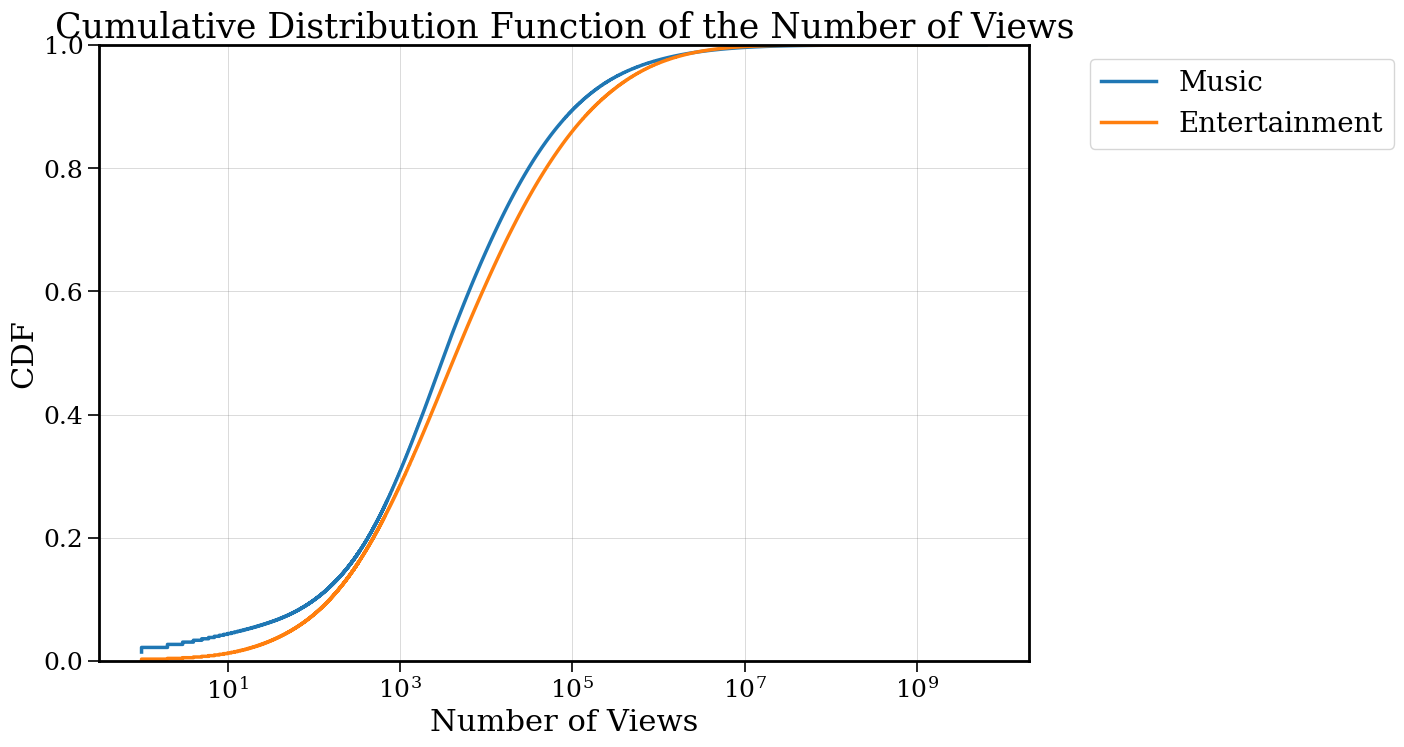

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.ecdfplot(data=df_views_music, x="view_count", complementary=False, ax=ax, label="Music", log_scale=True)
sns.ecdfplot(data=df_views_entertainment, x="view_count", complementary=False, ax=ax, label="Entertainment", log_scale=True)
ax.set_xlabel("Number of Views")
ax.set_ylabel("CDF")
ax.set_title("Cumulative Distribution Function of the Number of Views")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.4)
plt.show()

In [8]:
df_views.sample(5)

,display_id,view_count,categories
3909954,d6QzDSMXs_8,226596,1
16911592,Al4yZvyvnvk,74138,1
14387658,rzXqBlYbEgI,571,1
16182130,Xr5JDSZRPYY,1945,0
17700473,Dl6gn7Dlyfs,1840,1


In [9]:
# Keep only the top p% of the videos
p = 0.95
df_top_p_music = top_p_views(df_views_music, p)
df_top_p_entertainment = top_p_views(df_views_entertainment, p)

In [10]:
category_data = [
    ("Music", len(df_views_music), len(df_top_p_music), len(df_top_p_music) / len(df_views_music)),
    ("Entertainment", len(df_views_entertainment), len(df_top_p_entertainment), len(df_top_p_entertainment) / len(df_views_entertainment)),
]

header = f"{'Category':<15} {'Original Number of Videos':<30} {'Top Videos (90%)':<20} {'Fraction':<10}"
print(header)
print("-" * len(header))

for category, original_count, top_count, fraction in category_data:
    print(f"{category:<15} {original_count:<30} {top_count:<20} {fraction:<10.2%}")

Category        Original Number of Videos      Top Videos (90%)     Fraction  
------------------------------------------------------------------------------
Music           8197981                        541108               6.60%     
Entertainment   12015676                       1782414              14.83%    


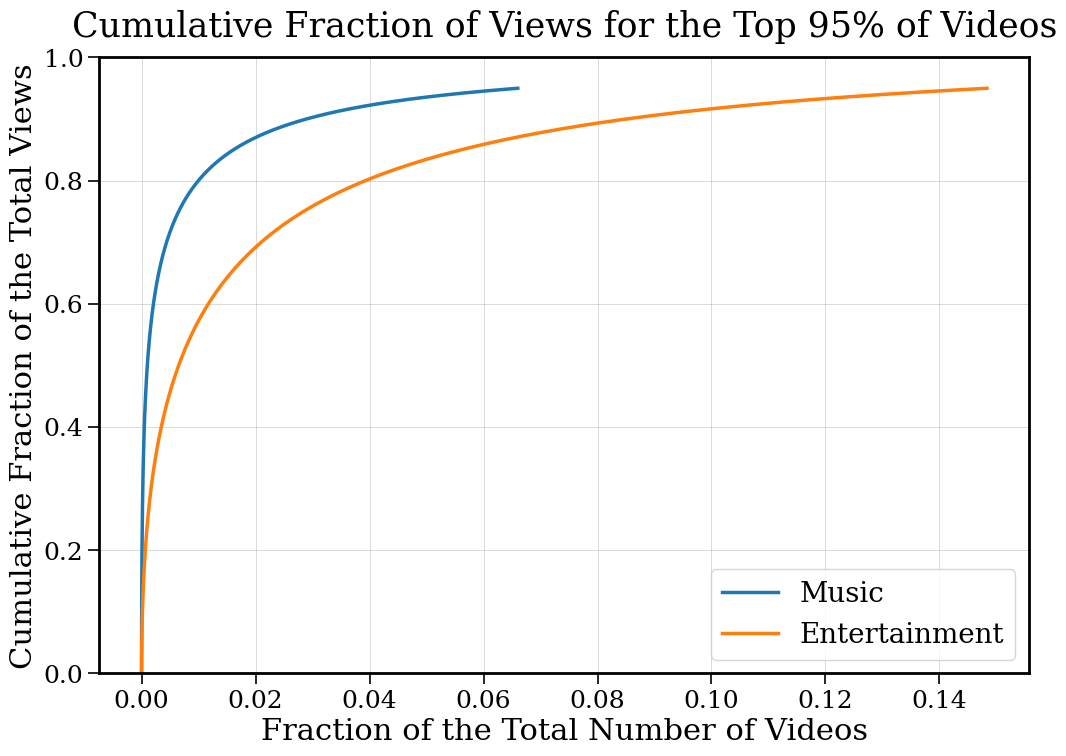

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Compute the fraction of the total number of videos that the top p% represent
fraction_music = len(df_top_p_music) / len(df_views_music)
fraction_entertainment = len(df_top_p_entertainment) / len(df_views_entertainment)
x_music = np.linspace(1 / len(df_views_music), fraction_music, len(df_top_p_music))
x_entertainment = np.linspace(1 / len(df_views_entertainment), fraction_entertainment, len(df_top_p_entertainment))

# Plot the cumulative fraction of views for the top p% of videos
sns.lineplot(x=x_music, y=df_top_p_music["cumulative_proportion"], label="Music", ax=ax)
sns.lineplot(x=x_entertainment, y=df_top_p_entertainment["cumulative_proportion"], label="Entertainment", ax=ax)
ax.set_xlabel("Fraction of the Total Number of Videos")
ax.set_ylabel("Cumulative Fraction of the Total Views")
ax.set_title(rf"Cumulative Fraction of Views for the Top {p*100:.0f}% of Videos", fontsize=25, pad=15)
ax.legend()

ax.set_ylim(0, 1)
ax.grid(True, alpha=0.4)
plt.show()

In [12]:
# for category, df_top_p in zip(["Music", "Entertainment"], [df_top_p_music, df_top_p_entertainment]):
#     process_top_p_videos(file_path="data/yt_metadata_filtered.jsonl.gz", output_path=f"data/top_{p*100}_{category}.jsonl.gz", top_p_videos=df_top_p)  

In [3]:
top_p_music = pd.read_json("data/top_95.0_Music.jsonl.gz", lines=True, compression="gzip")

In [4]:
top_p_entertainment = pd.read_json("data/top_95.0_Entertainment.jsonl.gz", lines=True, compression="gzip")

In [5]:
# Detect collaborations and sort the data by the number of views
top_p_music["collab"] = top_p_music["title"].apply(lambda x: data_utils.detect_collaboration(x))
top_p_entertainment["collab"] = top_p_entertainment["title"].apply(lambda x: data_utils.detect_collaboration(x))

top_p_entertainment = top_p_entertainment.sort_values(by="view_count", ascending=False)
top_p_music = top_p_music.sort_values(by="view_count", ascending=False)

In [6]:
# Compare the different distributions between collaborations and non collaborations for the Music category
columns = ["view_count", "like_count", "dislike_count"]
custom_labels = {"view_count": "Number of Views", "like_count": "Number of Likes", "dislike_count": "Number of Dislikes"}
x_logs = [True, True, True]
y_logs = [True, False, False]

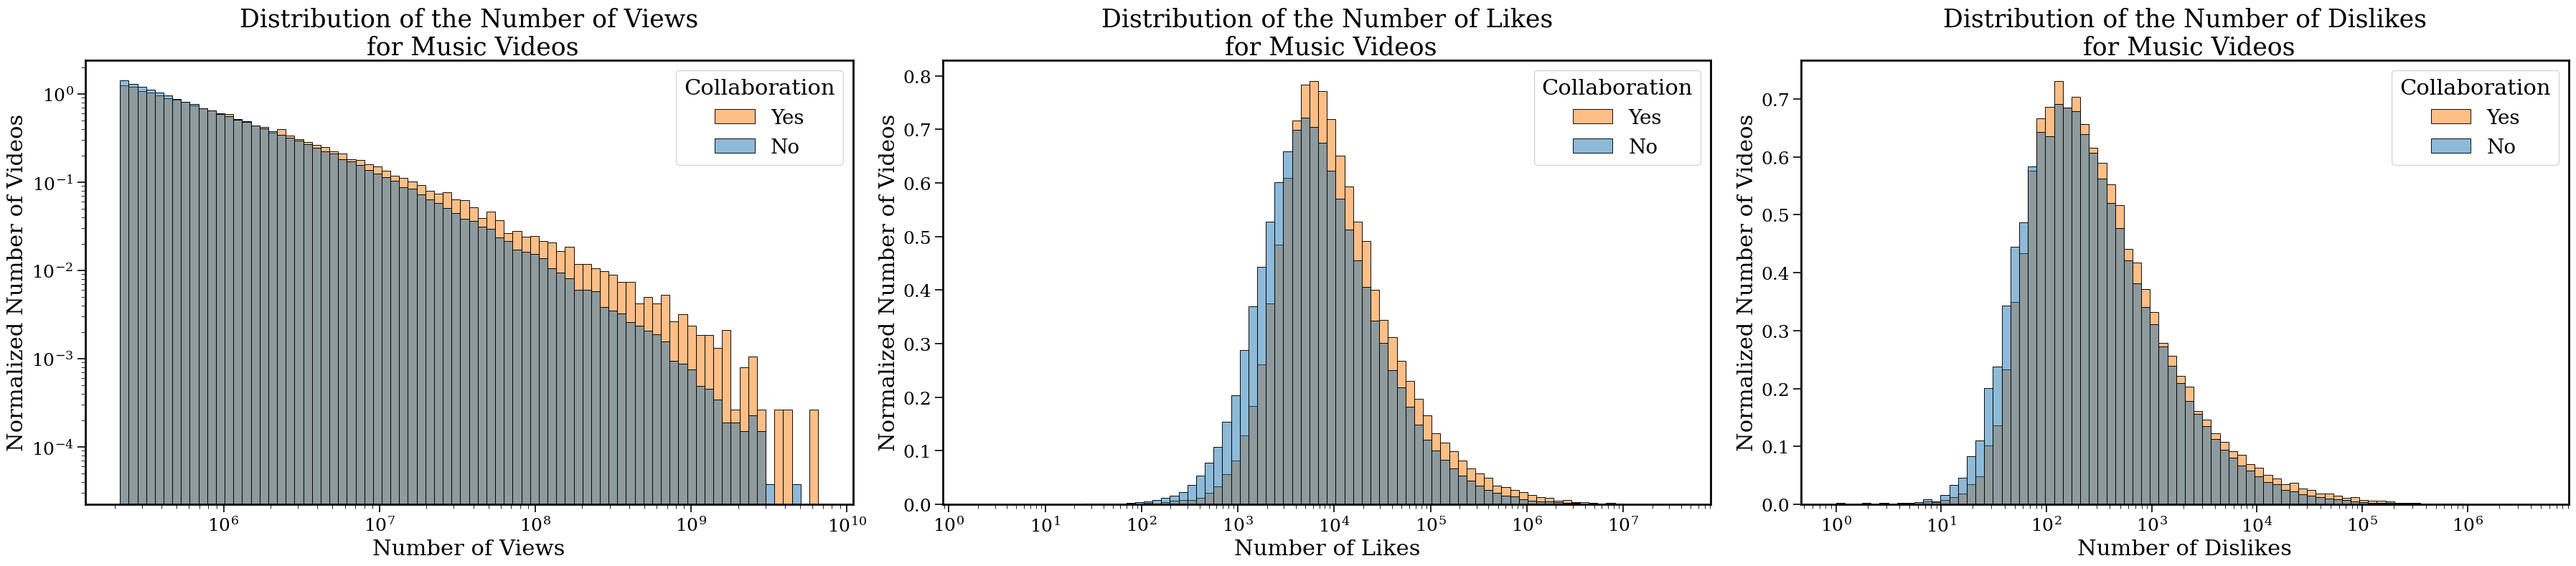

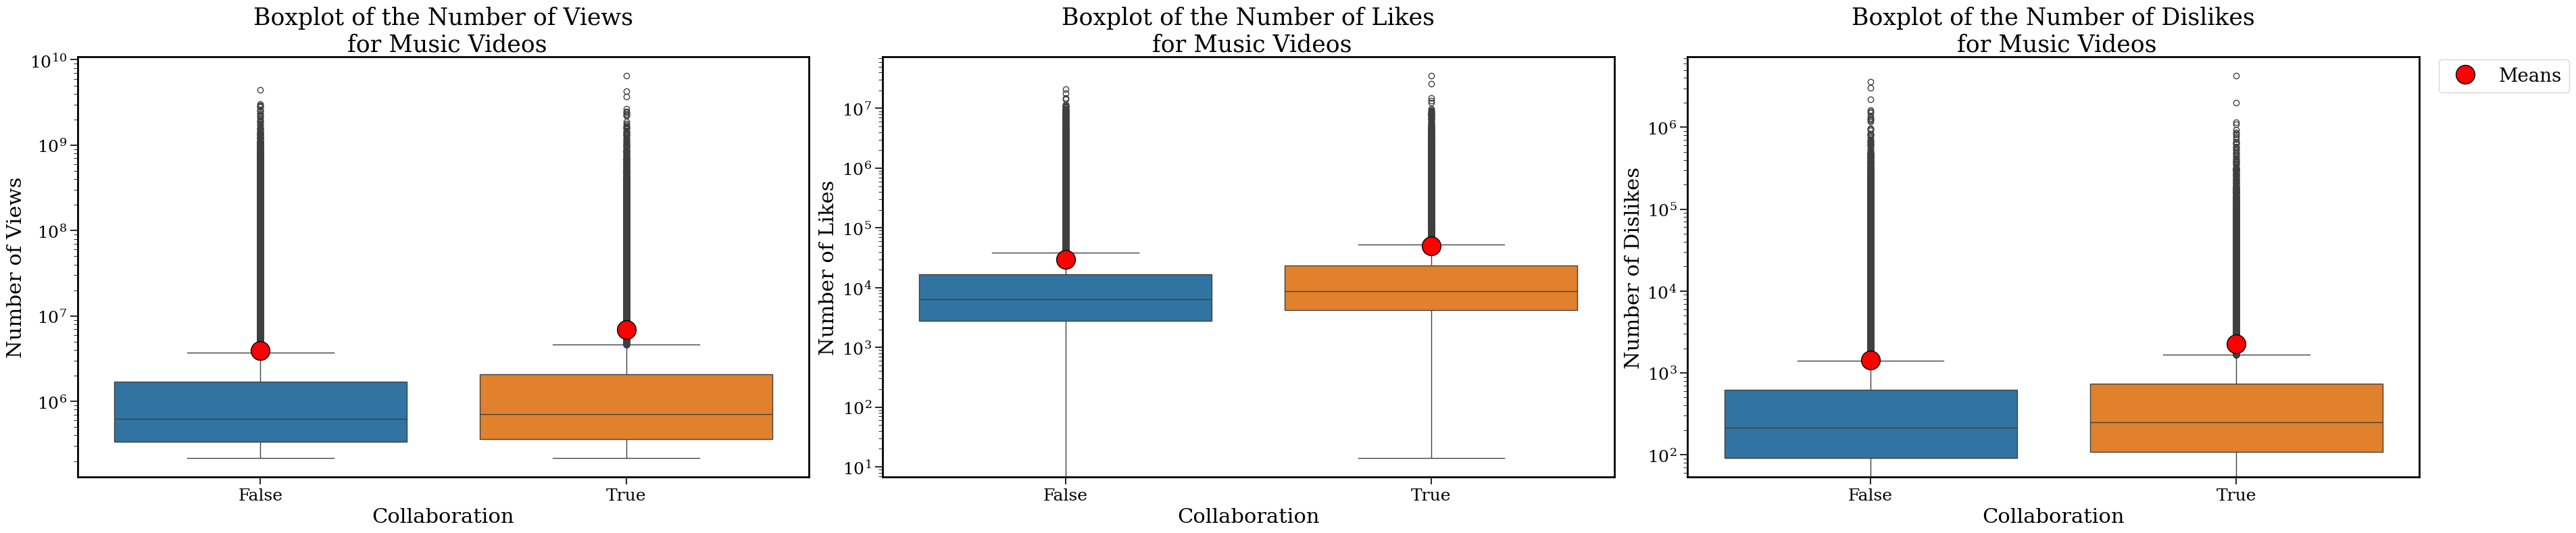

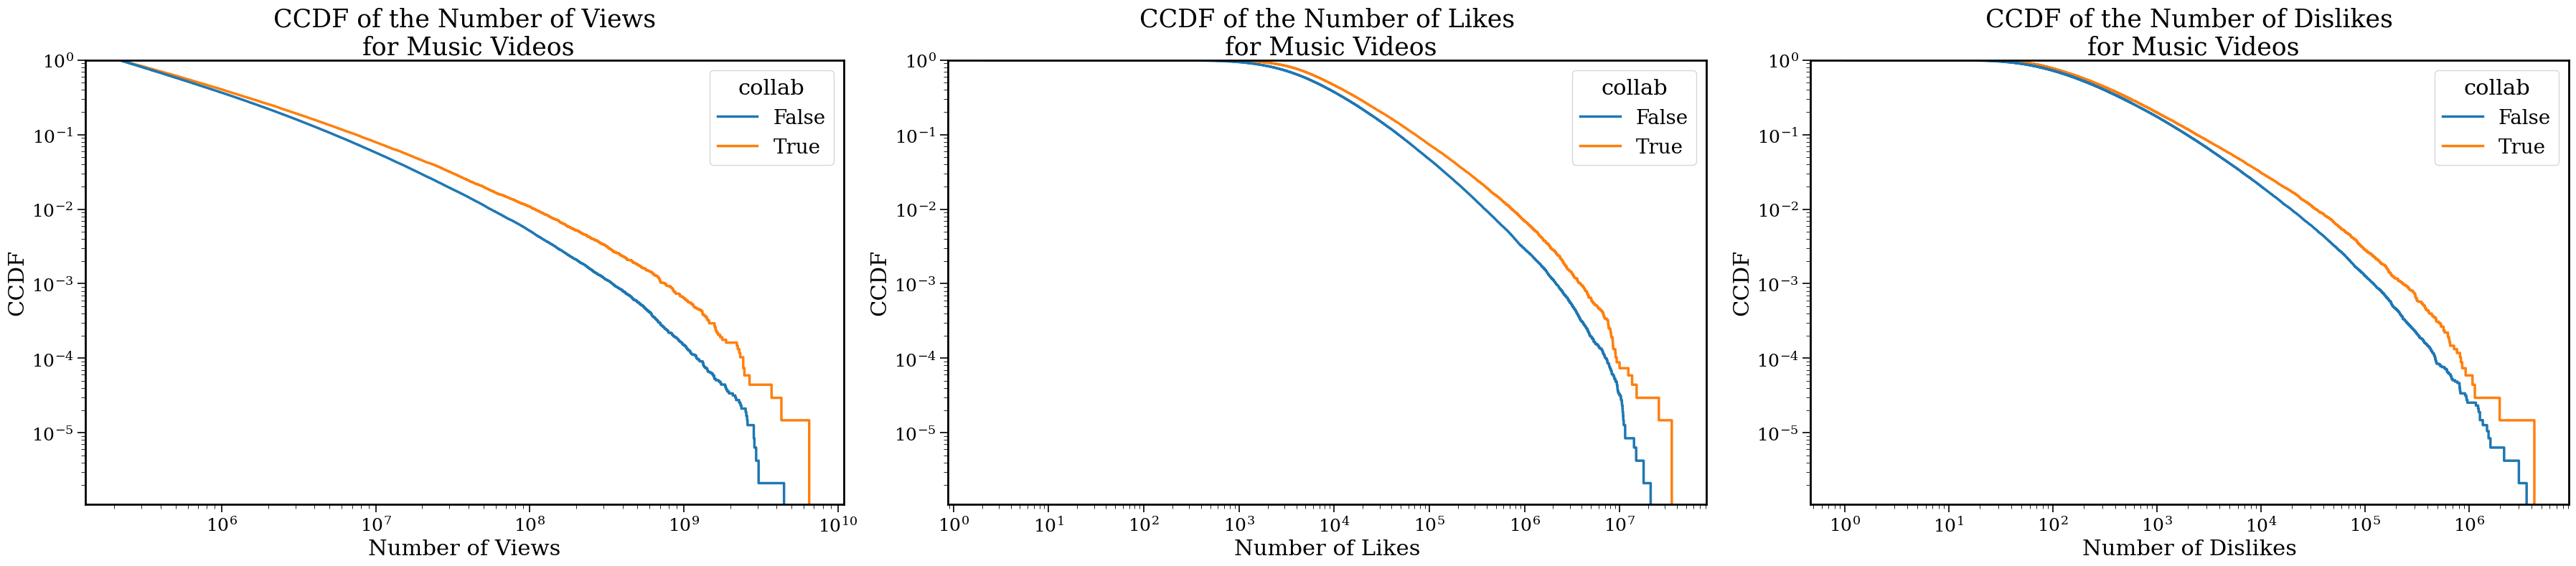

In [7]:
# Music Category 
# Histogram
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.histplot(data=top_p_music, x=col, hue="collab", hue_order=[False, True],  bins=80, common_norm=False, 
                 fill=True, stat="density", ax=ax[i], log_scale=x_log, legend=True)
    ax[i].set_xlabel(custom_labels[col])
    ax[i].set_ylabel("Normalized Number of Videos")
    ax[i].set_title(f"Distribution of the {custom_labels[col]}\n for Music Videos")
    ax[i].legend(title="Collaboration", labels=["Yes", "No"])
    if y_log:
        ax[i].set_yscale("log")
plt.tight_layout()
plt.show()

# Boxplot
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.boxplot(data=top_p_music, x="collab", hue="collab", y=col, ax=ax[i], legend=False, showmeans=True, 
                meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markersize': 20, 'markerfacecolor': 'red'})
    ax[i].set_xlabel("Collaboration")
    ax[i].set_ylabel(custom_labels[col])
    ax[i].set_title(f"Boxplot of the {custom_labels[col]}\n for Music Videos")
    ax[i].set_yscale("log")
    
mean_marker = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=20, label='Means')
fig.legend(handles=[mean_marker], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

# Complementary Cumulative Distribution Function (CCDF)
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.ecdfplot(data=top_p_music, x=col, hue="collab", complementary=True, ax=ax[i], legend=True, log_scale=x_log)
    ax[i].set_xlabel(custom_labels[col])
    ax[i].set_ylabel("CCDF")
    ax[i].set_title(f"CCDF of the {custom_labels[col]}\n for Music Videos")
    ax[i].set_yscale("log")
plt.tight_layout()
plt.show()

In [8]:
# Statistical tests to see if there is a significant difference between the distributions 
# of collaborations and non collaborations for the Music category
header = f"{'Test':<45}{'Statistic':<15}{'P-Value':<15}{'Significant?':<12}"
separator = "-" * len(header)
print(header)
print(separator)

for col in columns:
    music_collab = top_p_music[top_p_music["collab"] == True][col]
    music_non_collab = top_p_music[top_p_music["collab"] == False][col]

    # Mann-Whitney U test
    stat_u, pval_u = mannwhitneyu(music_collab, music_non_collab, alternative='two-sided')
    sig_u = "Yes" if pval_u < 0.05 else "No"
    print(f"{'Mann-Whitney U ('+custom_labels[col]+')':<45}{stat_u:<15.2e}{pval_u:<15.2e}{sig_u:<12}")

    # Kolmogorov-Smirnov test
    stat_ks, pval_ks = ks_2samp(music_collab, music_non_collab)
    sig_ks = "Yes" if pval_ks < 0.05 else "No"
    print(f"{'Kolmogorov-Smirnov ('+custom_labels[col]+')':<45}{stat_ks:<15.2e}{pval_ks:<15.2e}{sig_ks:<12}")

    # Cramér-von Mises test
    result = cramervonmises_2samp(music_collab, music_non_collab)
    stat_cv = result.statistic
    pval_cv = result.pvalue
    sig_cv = "Yes" if pval_cv < 0.05 else "No"
    print(f"{'Cramér-von Mises ('+custom_labels[col]+')':<45}{stat_cv:<15.2e}{pval_cv:<15.2e}{sig_cv:<12}")

    print(separator)

Test                                         Statistic      P-Value        Significant?
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Views)             1.70e+10       1.06e-122      Yes         
Kolmogorov-Smirnov (Number of Views)         3.88e-02       5.36e-78       Yes         
Cramér-von Mises (Number of Views)           5.27e+01       2.29e-08       Yes         
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Likes)             1.86e+10       0.00e+00       Yes         
Kolmogorov-Smirnov (Number of Likes)         1.20e-01       0.00e+00       Yes         
Cramér-von Mises (Number of Likes)           4.38e+02       1.37e-07       Yes         
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Dislikes)          1.72e+10       4.55e-207      Yes         
Kolmogorov-Smirnov (Number of Di

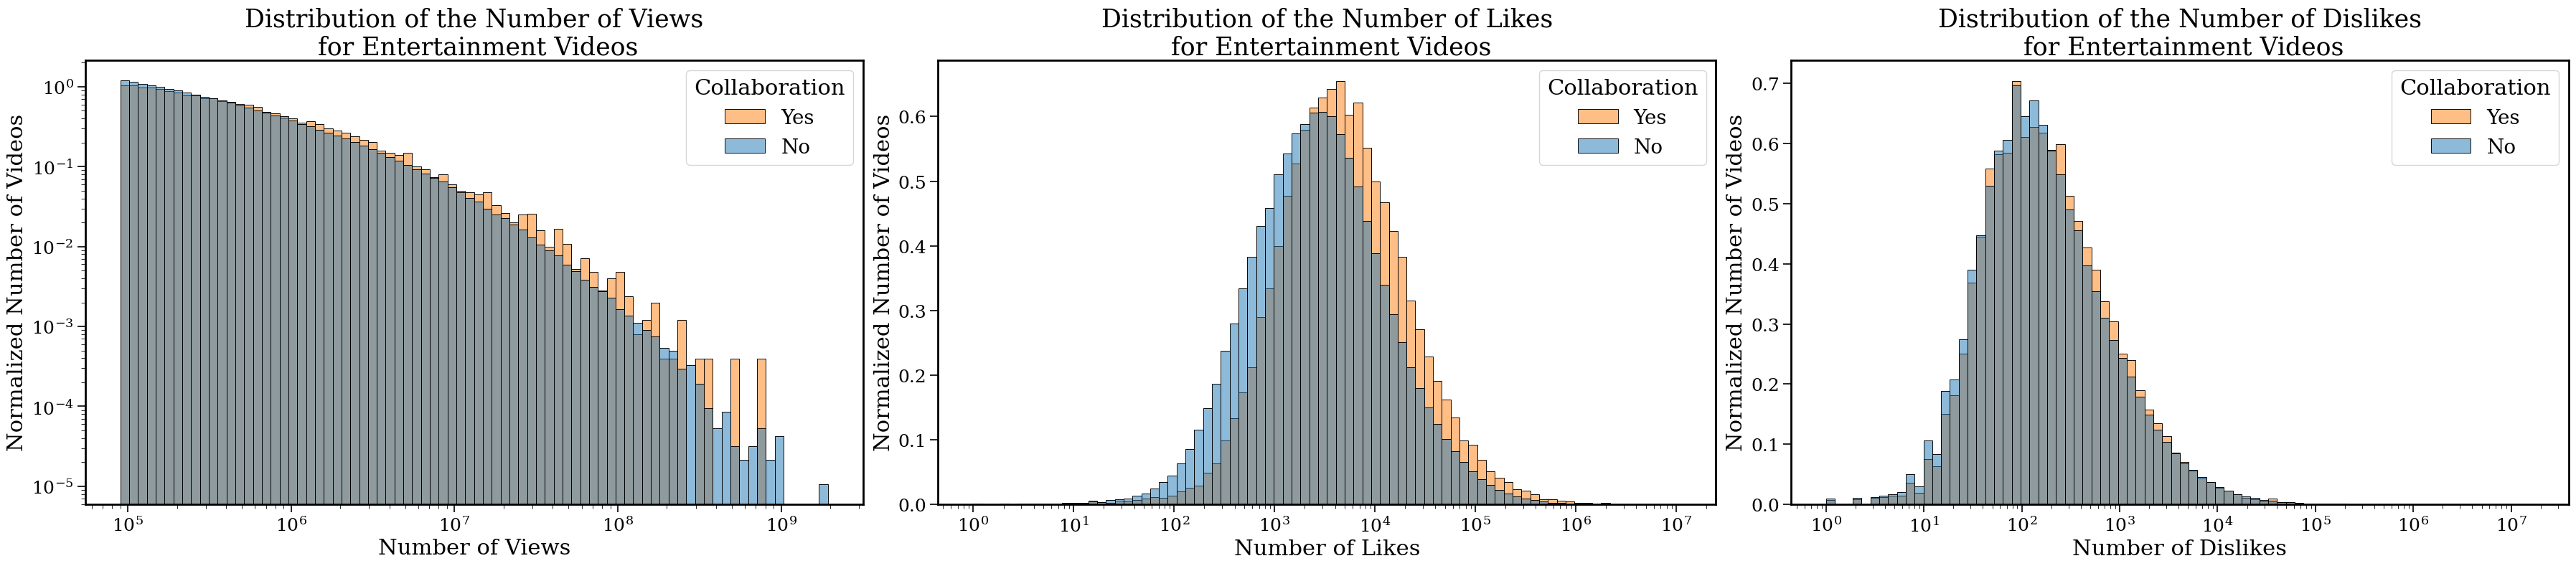

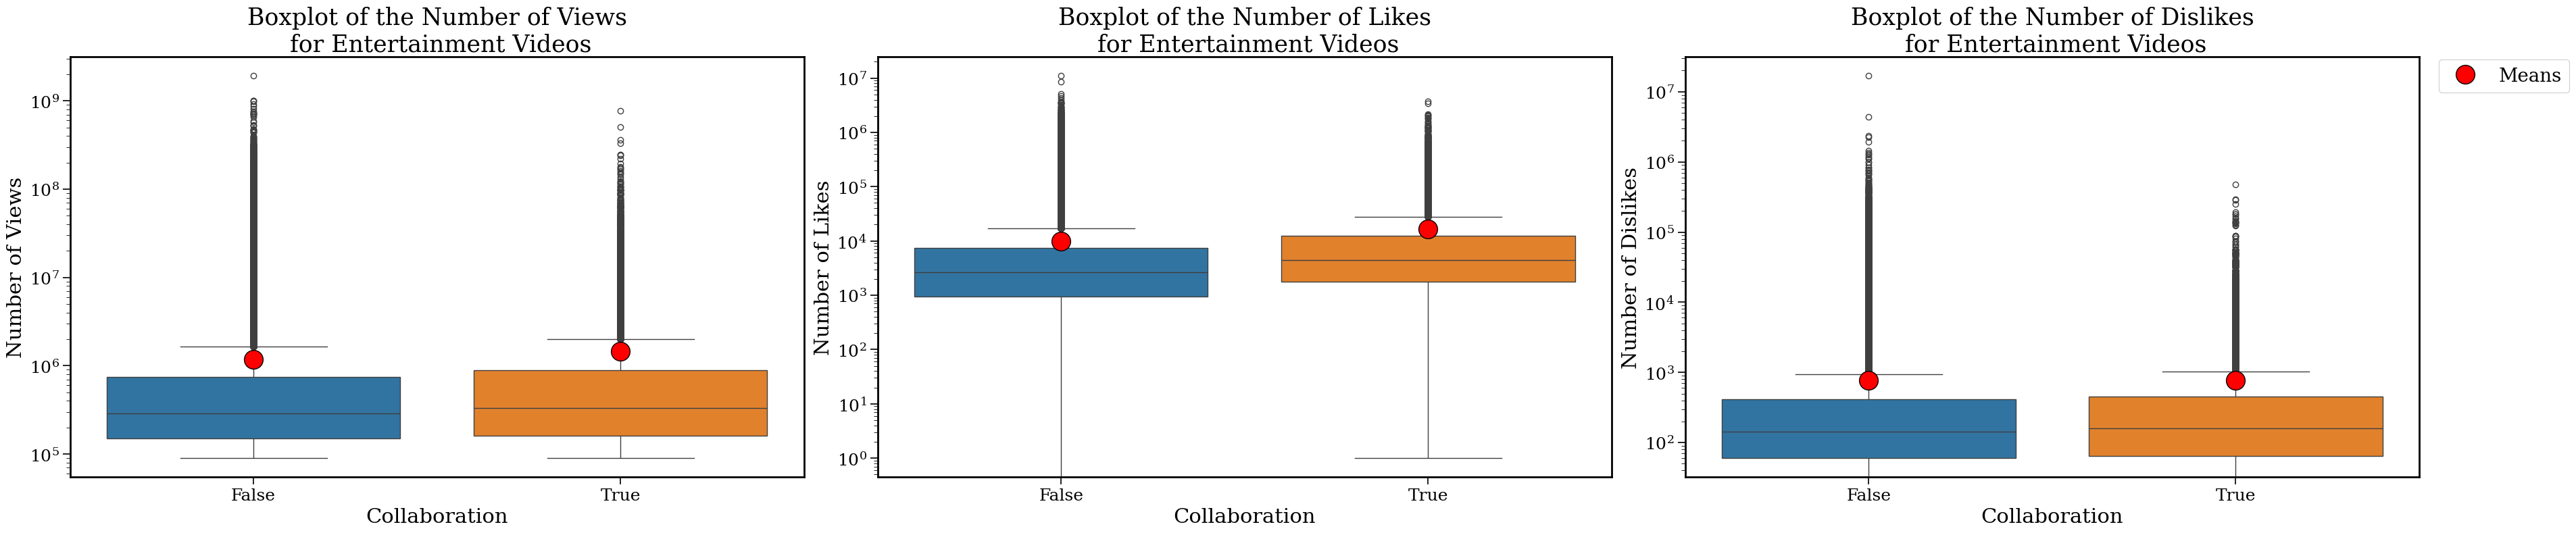

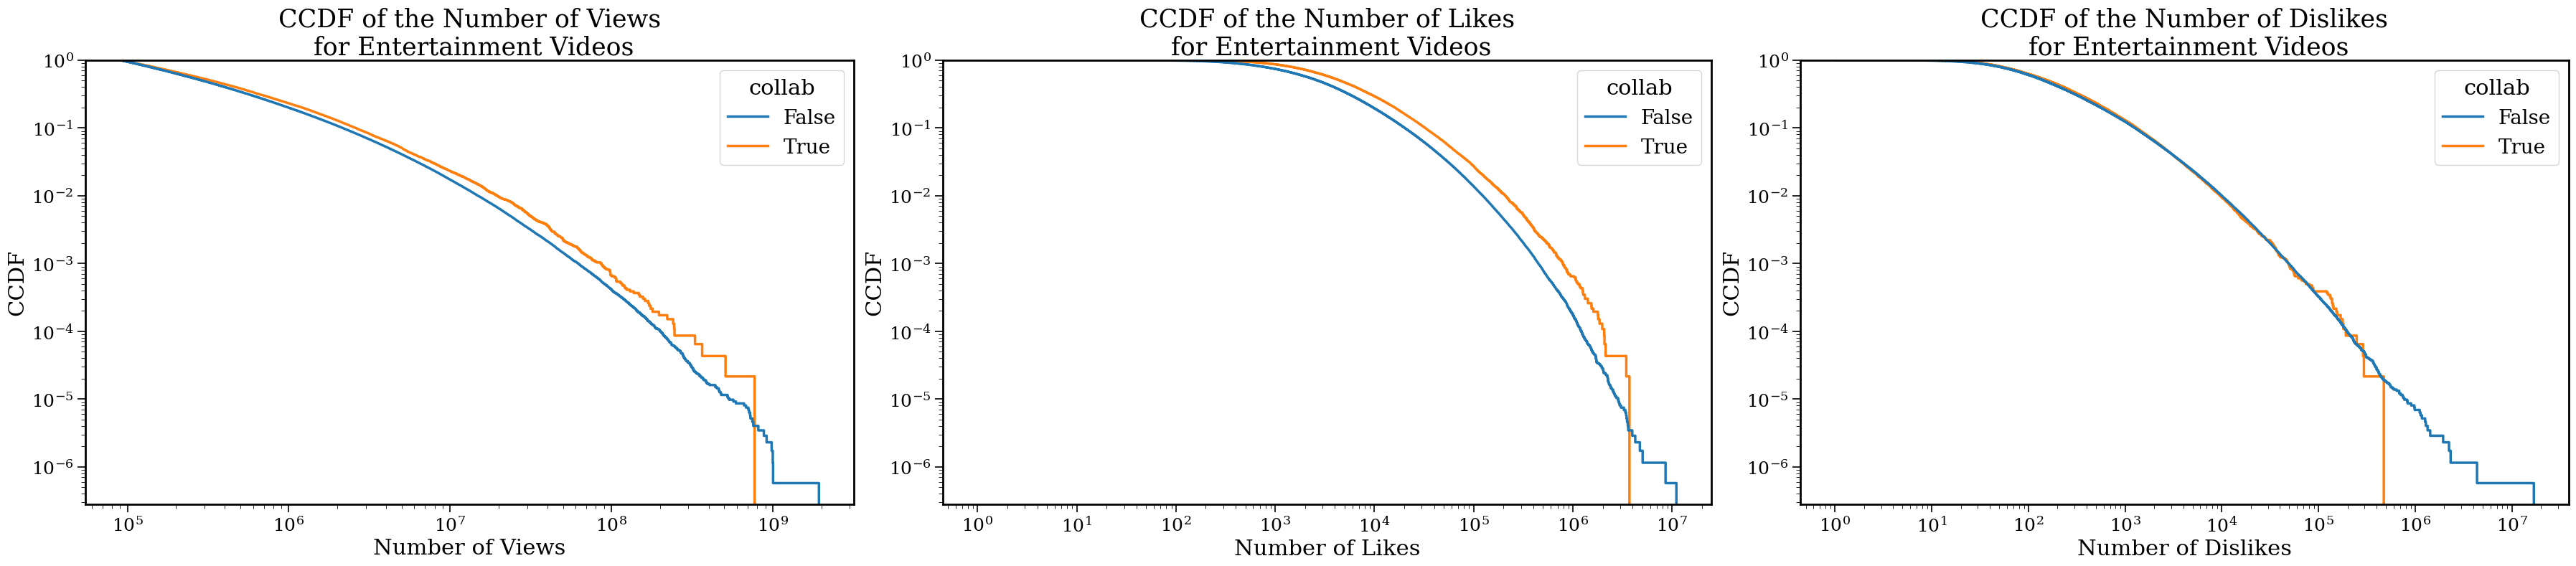

In [9]:
# Entertainment Category 

# Histogram
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.histplot(data=top_p_entertainment, x=col, hue="collab", hue_order=[False, True],  
                 bins=80, common_norm=False, fill=True, stat="density", ax=ax[i], log_scale=x_log)
    ax[i].set_xlabel(custom_labels[col])
    ax[i].set_ylabel("Normalized Number of Videos")
    ax[i].set_title(f"Distribution of the {custom_labels[col]}\n for Entertainment Videos")
    ax[i].legend(title="Collaboration", labels=["Yes", "No"])
    if y_log:
        ax[i].set_yscale("log")
plt.tight_layout()
plt.show()

# Boxplot
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.boxplot(data=top_p_entertainment, x="collab", hue="collab", y=col, ax=ax[i], legend=False, showmeans=True, 
                meanprops={'marker': 'o', 'markeredgecolor': 'black', 'markersize': 20, 'markerfacecolor': 'red'})
    ax[i].set_xlabel("Collaboration")
    ax[i].set_ylabel(custom_labels[col])
    ax[i].set_title(f"Boxplot of the {custom_labels[col]}\n for Entertainment Videos")
    ax[i].set_yscale("log")
mean_marker = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                     markeredgecolor='black', markersize=20, label='Means')
fig.legend(handles=[mean_marker], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

# Complementary Cumulative Distribution Function (CCDF)
fig, ax = plt.subplots(1, len(columns), figsize=(12*len(columns), 8))
for i, (col, x_log, y_log) in enumerate(zip(columns, x_logs, y_logs)):
    sns.ecdfplot(data=top_p_entertainment, x=col, hue="collab", complementary=True, ax=ax[i], legend=True, log_scale=x_log)
    ax[i].set_xlabel(custom_labels[col])
    ax[i].set_ylabel("CCDF")
    ax[i].set_title(f"CCDF of the {custom_labels[col]}\n for Entertainment Videos")
    ax[i].set_yscale("log")
plt.tight_layout()
plt.show()

In [10]:
# Statistical tests to see if there is a significant difference between the distributions 
# of collaborations and non collaborations for the Entertainment category
header = f"{'Test':<45}{'Statistic':<15}{'P-Value':<15}{'Significant?':<12}"
separator = "-" * len(header)
print(header)
print(separator)

for col in columns:
    entertainment_collab = top_p_entertainment[top_p_entertainment["collab"] == True][col]
    entertainment_non_collab = top_p_entertainment[top_p_entertainment["collab"] == False][col]

    # Mann-Whitney U test
    stat_u, pval_u = mannwhitneyu(entertainment_collab, entertainment_non_collab, alternative='two-sided')
    sig_u = "Yes" if pval_u < 0.05 else "No"
    print(f"{'Mann-Whitney U ('+custom_labels[col]+')':<45}{stat_u:<15.2e}{pval_u:<15.2e}{sig_u:<12}")

    # Kolmogorov-Smirnov test
    stat_ks, pval_ks = ks_2samp(entertainment_collab, entertainment_non_collab)
    sig_ks = "Yes" if pval_ks < 0.05 else "No"
    print(f"{'Kolmogorov-Smirnov ('+custom_labels[col]+')':<45}{stat_ks:<15.2e}{pval_ks:<15.2e}{sig_ks:<12}")

    # Cramér-von Mises test
    result = cramervonmises_2samp(entertainment_collab, entertainment_non_collab)
    stat_cv = result.statistic
    pval_cv = result.pvalue
    sig_cv = "Yes" if pval_cv < 0.05 else "No"
    print(f"{'Cramér-von Mises ('+custom_labels[col]+')':<45}{stat_cv:<15.2e}{pval_cv:<15.2e}{sig_cv:<12}")
    
    print(separator)

Test                                         Statistic      P-Value        Significant?
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Views)             4.24e+10       5.68e-90       Yes         
Kolmogorov-Smirnov (Number of Views)         4.22e-02       3.34e-70       Yes         
Cramér-von Mises (Number of Views)           4.01e+01       1.11e-08       Yes         
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Likes)             4.85e+10       0.00e+00       Yes         
Kolmogorov-Smirnov (Number of Likes)         1.45e-01       0.00e+00       Yes         
Cramér-von Mises (Number of Likes)           5.53e+02       1.54e-07       Yes         
---------------------------------------------------------------------------------------
Mann-Whitney U (Number of Dislikes)          4.15e+10       3.82e-31       Yes         
Kolmogorov-Smirnov (Number of Di